# Lab 3: Linear Regression

This exercise takes you through the fundamental linear regression model from a number of different angles. First we consider an analytic analysis and then we continue to consider how to solve the same problem using numerical methods. This lab also serves and an introduction to the tensorflow toolkit which will be useful for a variety of machine learning tasks in the future and is used by Google to solve massive machine learning problems on their clusters.

The linear regression model forms the basis for a whole host of models - if you are comfortable with the fundamental approaches we take here, there will be a whole range of extensions, advances and applications available to you in the future.

In [1]:
%matplotlib inline
import numpy as np

# A new one for this lab!
import tensorflow.compat.v1 as tf

from sklearn import datasets as ds

import matplotlib.pyplot as plt

In [2]:
boston = ds.load_boston()

x_raw = boston.data[:,np.argwhere(boston.feature_names == 'RM')[0,0]]
y_raw = boston.target

## Boston House Prices Dataset
A descroption of the dataset used is provided here.

Data Set Characteristics:  
    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
        - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
        - LSTAT    % lower status of the population
        - MEDV     Median value of owner-occupied homes in $1000's

    :Missing Attribute Values: None

    :Creator: Harrison, D. and Rubinfeld, D.L.

This is a copy of UCI ML housing dataset.
http://archive.ics.uci.edu/ml/datasets/Housing


This dataset was taken from the StatLib library which is maintained at Carnegie Mellon University.

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
...', Wiley, 1980.   N.B. Various transformations are used in the table on
pages 244-261 of the latter.

The Boston house-price data has been used in many machine learning papers that address regression
problems.   
     
### References

   - Belsley, Kuh & Welsch, 'Regression diagnostics: Identifying Influential Data and Sources of Collinearity', Wiley, 1980. 244-261.
   - Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning. In Proceedings on the Tenth International Conference of Machine Learning, 236-243, University of Massachusetts, Amherst. Morgan Kaufmann.
   - many more! (see http://archive.ics.uci.edu/ml/datasets/Housing)

## Preparing the data

We are going to look at the relationship between the "average number of rooms per dwelling" and median house price in the Boston dataset. First let us partition the data into a training and test split. We are going for 60% training and 40% testing.

In [3]:
total_count = x_raw.shape[0]

split = int(total_count * 0.6)

# Shuffle the data to avoid any ordering bias..
np.random.seed(0)
shuffle = np.random.permutation(total_count)

x = x_raw[shuffle]
y = y_raw[shuffle]

x_train_unnormalised = x[:split]
y_train_unnormalised = y[:split]

x_test_unnormalised = x[split:]
y_test_unnormalised = y[split:]

print('Training set size:', x_train_unnormalised.shape[0])
print('Test set size:', x_test_unnormalised.shape[0])

Training set size: 303
Test set size: 203


## Data Visualisation

To allow for easy visualisation as you progress through the task we are using a single dimensional data set. Both the input $x$ and output $y$ are scalars so we can plot them on a standard scatter plot.

Text(0.5, 1.0, 'Plot of the Training Data')

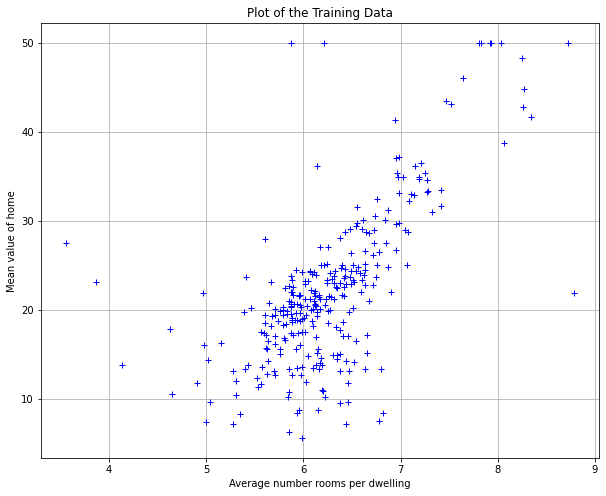

In [4]:
# You can use this function to plot the data and then add your own plots on top..
def plot_data(x, y):
    plt.figure(figsize=[10,8])
    plt.plot(x, y, 'b+')
    plt.grid(True)
    plt.xlabel('Average number rooms per dwelling')
    plt.ylabel('Mean value of home')

plot_data(x_train_unnormalised, y_train_unnormalised)
plt.title('Plot of the Training Data')

### Question 1 (2 marks):

Write a function that normalises a vector of values. It should output a corresponding vector where the values have a mean of zero and a standard deviation of 1. Note that you should only perform an affine transformation of the data (i.e. a linear scaling and a fixed offset). This means that you must find $a$ and $b$ for $u_i = a \, v_i + b$ where $\{u_i\}$ are the input data and $\{v_i\}$ are the normalised output data.

Your function should return the normalising constants as well as the normalised data.

Write a second function that removes the normalisation and returns the data to its original values.

Check that passing both `x_train` and `y_train` through both functions returns the vectors to their original values.

*Hints:*
- You might want to look at `np.all()` for the Boolean check that they return to their values.
- When checking that floating point values are equal up to nummerical precision (e.g. rounding errors in the computations) you can use the `np.isclose()` function.
- You can use the `assert()` command to guarantee that a statement is `True` before the program continues.

*Points to consider:* 
- Why might it be sensible to normalise the data in the fashion described?
- Considering that we are about to perform Linear Regression, why might we not want to perform a more involved normalisation process?

Passes checking function :)


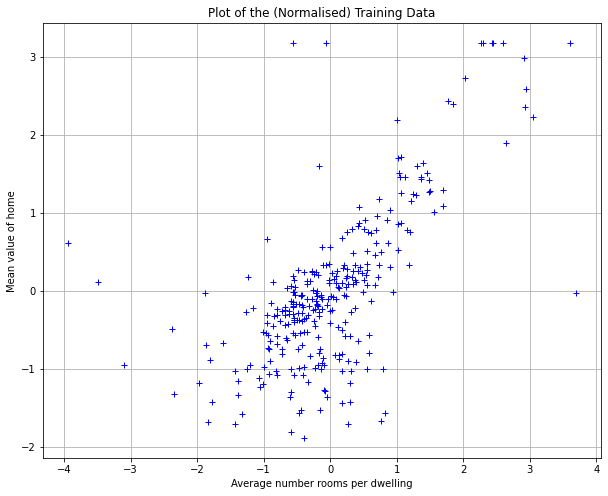

In [5]:
def normalise_data(x_unnormalised):
    # Add your code here..
    # ************************************************************
    b = x_unnormalised.mean()
    a = x_unnormalised.std()
    
    x_normalised = (x_unnormalised - b)/a
    
    return x_normalised, a, b

def unnormalise_data(x_normalised, a, b):
    # Add your code here..
    # ************************************************************
    x_unnormalised = (x_normalised * a) + b
    
    return x_unnormalised

try:
    x_train, x_norm_a, x_norm_b = normalise_data(x_train_unnormalised)
    y_train, y_norm_a, y_norm_b = normalise_data(y_train_unnormalised)

    x_test, _, _ = normalise_data(x_test_unnormalised)
    y_test, _, _ = normalise_data(y_test_unnormalised)
except Exception as err:
    print('Error during normalisation functions:', err)

def checking_function(normalise_data, unnormalise_data, data_to_check):
    passes_check = False
    
    est_normalised_data, est_a, est_b = normalise_data(data_to_check)
    est_unnormalised_data = unnormalise_data(est_normalised_data, est_a, est_b)
    
    # Add your code here to check that the unnormaliseding the 
    # training data returns to their original values and update 
    # the passes_check boolean..
    # ************************************************************
    passes_total = np.isclose(data_to_check , est_unnormalised_data)

    passes_check = np.all(passes_total)

    assert(passes_check)
    
    return passes_check

try:
    if (checking_function(normalise_data, unnormalise_data, x_train_unnormalised) == True) and \
       (checking_function(normalise_data, unnormalise_data, y_train_unnormalised) == True):
        print('Passes checking function :)')
    else:
        print('Failed to pass the checking function :(')
except Exception as err:
    print('Error during checking function:', err)

# Plot the data to make sure they are normalised..
try:
    plot_data(x_train, y_train)
    plt.title('Plot of the (Normalised) Training Data')
except Exception as err:
    print('Error during ploting functions:', err)

## The Linear Regression Model

In linear regression we are trying to fit a linear model to the data of the form

\begin{align}
y &= w x + c
\end{align}

where $w$ and $c$ are parameters to be learned that take the input data $x$ to the output data $y$. Once this model has been learned, we can use the parameters to predict the values of the output that would correspond to new values of the input.

In order to determine the parameters, we need an objective function that we seek to optimise: this function returns a scalar value for all possible parameter values and we seek to change the parameters until the best scalar value is obtained.

For linear regression, we usually take the objective as one which minimises the squared error; this is known as a linear least squares problem.

*Aside: Think about what this means in terms of a model for the data when you have $y = f(x) + \eta$ with $f(x)$ as a linear function $f(x) = w x + c$ and $\eta$ as iid Gaussian noise.*

Therefore our objective is given by the sum of squared differences between the true value of $y_i$ and the value estimated by our model $w x_i + c$.

\begin{align}
E(w,c) &= \sum_{i=0}^{N-1} \big(y_i - f(x_i) \big)^2 \\
    &= \sum_{i=0}^{N-1} \big(y_i - (w x_i + c) \big)^2 \\
    &= \sum_{i=0}^{N-1} \big(y_i - w x_i - c \big)^2
\end{align}



## Question 2 (1 mark)

Write a function that calculates the least squared error on the training data for a particular value of the parameters $w$ and $c$.

In [6]:
def least_squares_error(x, y, w, c):
    # Add code to calcuate the squared_error = E(w,c)..
    # ************************************************************
    E_presum = ((y - x*w) - c) ** 2
    
    squared_error = E_presum.sum()
    
    return squared_error

try:
    print('Squared error for w = 1.5, c = 0.5 is ', 
          least_squares_error(x_train, y_train, w=1.5, c=0.5))
except Exception as err:
    print('Error during least squares calculation:', err)

Squared error for w = 1.5, c = 0.5 is  450.52041703162615


## Analytic Solution

In the case of linear regression, we can find an analytic solution to this problem by finding stationary point of the objective function. We do this by evaluating the partial derivatives of the objective wrt each parameter in turn and setting them to zero. If we can then find a solution to these simultaneous equations, we have found an optimal setting for the parameters.

For $w$ we have:

\begin{align}
\frac{\partial E}{\partial w} 
    &= \frac{\partial}{\partial w}\sum_{i=0}^{N-1} \big(y_i - w x_i - c \big)^2 \\
    &= \sum_{i=0}^{N-1} \frac{\partial}{\partial w} \big(y_i - w x_i - c \big)^2 \\
    &= \sum_{i=0}^{N-1} 2 \big(y_i - w x_i - c \big) \frac{\partial}{\partial w} \big(y_i - w x_i - c \big) \\
    &= \sum_{i=0}^{N-1} 2 \big(y_i - w x_i - c \big) \big(- x_i \big) \\
    &= \sum_{i=0}^{N-1} 2 x_i (w x_i + c - y_i) \\
\end{align}

For $c$ we have:

\begin{align}
\frac{\partial E}{\partial c} 
    &= \frac{\partial}{\partial c}\sum_{i=0}^{N-1} \big(y_i - w x_i - c \big)^2 \\
    &= \sum_{i=0}^{N-1} \frac{\partial}{\partial c} \big(y_i - w x_i - c \big)^2 \\
    &= \sum_{i=0}^{N-1} 2 \big(y_i - w x_i - c \big) \frac{\partial}{\partial c} \big(y_i - w x_i - c \big) \\
    &= \sum_{i=0}^{N-1} 2 \big(y_i - w x_i - c \big) \big(- 1 \big) \\
    &= \sum_{i=0}^{N-1} 2 (w x_i + c - y_i) \\
\end{align}

Now setting $\frac{\partial E}{\partial w} = 0$:

\begin{align}
\Rightarrow \sum_{i=0}^{N-1} x_i (w x_i + c - y_i) &= 0 \\
w \sum_{i=0}^{N-1} (x_i)^2 + c \sum_{i=0}^{N-1} (x_i) - \sum_{i=0}^{N-1} (x_i y_i) &= 0 \\
\Rightarrow A w + B c - C &= 0 \qquad\text{(1)}
\end{align}

with $A = \sum_{i=0}^{N-1} (x_i)^2$, $B = \sum_{i=0}^{N-1} (x_i)$ and $C = \sum_{i=0}^{N-1} (x_i y_i)$.

Now setting $\frac{\partial E}{\partial c} = 0$:

\begin{align}
\Rightarrow \sum_{i=0}^{N-1} (w x_i + c - y_i) &= 0 \\
w \sum_{i=0}^{N-1} (x_i) + N c - \sum_{i=0}^{N-1} (y_i) &= 0 \\
\Rightarrow B w + N c - D &= 0 \qquad\text{(2)}
\end{align}

with $D = \sum_{i=0}^{N-1} (y_i)$.

Equations (1) and (2) can be combined to solve for the optimal values for $w$ and $c$! <p style="color:red">**You will need to finish the final part of the maths to write the function required in question 3.**</p>

## Question 3 (3 marks)

Write a function using numpy that takes as input `x_train` and `y_train` and outputs the optimal $w$ and $c$ parameters for least squares linear regression.

Confirm that your results are reasonable by plotting the resulting linear function on the training graph as well as the predicted values for the test set on a separate graph.

- 2 marks for the correct solution for $w$ and $c$
- 1 mark for the plots

Analytic solution:
Analytic w =  0.6710446457297836
Analytic c =  1.2195548195136355e-15


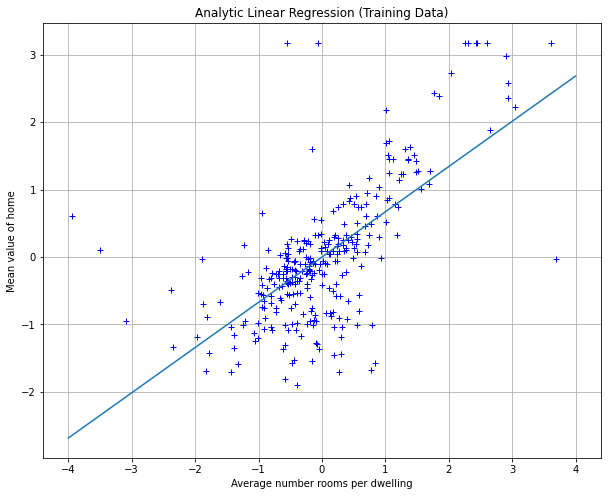

Mean least squares error on TRAINING data =  0.5496990834373896


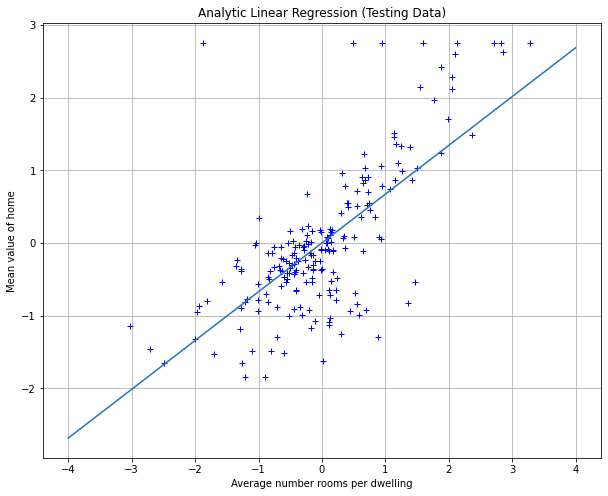

Mean least squares error on TEST data =  0.477446115537434


In [7]:
def least_squares_analytic_solution(x, y):
    # Add code to calcuate the optimal w and c using the 
    # equations above..
    # ************************************************************
    A = (x ** 2).sum()
    B = x.sum()
    C = (x * y).sum()
    D = y.sum()
    N = float(len(x))
    
    c = (C - (A * D) / B) / (B - (A * N) / B)
    w = (C - (B * D) / N) / (A - (B ** 2) / N)
    
    return w, c


try:
    w_opt, c_opt = least_squares_analytic_solution(x_train, y_train)
    
    print('Analytic solution:')
    print('Analytic w = ', w_opt)
    print('Analytic c = ', c_opt)
    
except Exception as err:
    print('Error during least squares analytic solution:', err)

    
def plot_estimated_y_for_input_x(w, c):
    # Add code to plot a line showing your solution 
    # for w and c..
    # ************************************************************
    x = np.arange(-4,5)
    y = w * x + c
    
    plt.plot(x,y)
    
    plt.show()
    pass
    
    

try:
    plot_data(x_train, y_train)
    plt.title('Analytic Linear Regression (Training Data)')
    plot_estimated_y_for_input_x(w_opt, c_opt)
    
    print('Mean least squares error on TRAINING data = ',
          least_squares_error(x_train, y_train, w_opt, c_opt) / x_train.shape[0])

    plot_data(x_test, y_test)
    plt.title('Analytic Linear Regression (Testing Data)')
    plot_estimated_y_for_input_x(w_opt, c_opt)
    
    print('Mean least squares error on TEST data = ',
          least_squares_error(x_test, y_test, w_opt, c_opt) / x_test.shape[0])
    
except Exception as err:
    print('Error during plotting:', err)

## Tensorflow Optimisation

In the previous question we looked at an analytic solution to the least square problem. We now pretend that we could not solve the problem analytically. Although this is not true for this case, the additional of extensions to the linear regression model (for example to improve robustness, adding feature selection or handling non-linear data) can mean that it is no longer possible to find an analytic solution and numerical optimisation must be used.

## Question 4 (2 marks)

Add the tensorflow expressions to the following code to calculate the least squares error using tensorflow and check that it calculates the same value as the numpy version.


In [8]:
tf.reset_default_graph()

try:
    # Constants to hold the training data..
    t_x_train = tf.constant(x_train, name='x_train')
    t_y_train = tf.constant(y_train, name='y_train')
except Exception as err:
    print('Error defining training data:', err)
    
# Initial values for optimisation..
w_initial_guess = 1.5
c_initial_guess = 0.5

# Variables to hold w and c
t_w = tf.Variable(w_initial_guess, 
                  dtype=tf.float64, 
                  name='w')
t_c = tf.Variable(c_initial_guess, 
                  dtype=tf.float64, 
                  name='c')


def calculate_tf_least_squares_error(t_x_train, t_y_train, t_w, t_c):
    # Add your code here to calculate t_least_squares_error..
    # ************************************************************
    
    # Create the tensors for the equation 
    t_x_w = t_x_train * t_w
    t_y_minus_wx_minus_c = t_y_train - t_x_w - t_c 
    t_E_terms = t_y_minus_wx_minus_c ** 2
    t_E = tf.reduce_sum(t_E_terms)
        
    t_least_squares_error = t_E
    print(t_E)
        
    
    return t_least_squares_error


try:
    tensorflow_result = calculate_tf_least_squares_error(t_x_train, t_y_train, t_w, t_c)
except Exception as err:
    print('Error declaration of calculate_tf_least_squares_error():', err)
    
try:
    # Check with the result from your previous function..
    numpy_result = least_squares_error(x_train, y_train, 
                                       w=w_initial_guess, 
                                       c=c_initial_guess)
    print('Tensorflow least squares error = ', tensorflow_result.numpy())
    print('numpy least squares error = ', numpy_result)    
    
    # This should pass if they are the same to nummerical precision!
    assert(np.isclose(tensorflow_result, numpy_result))
except Exception as err:
    print('Error during optimisation with calculate_tf_least_squares_error():', err)

tf.Tensor(450.52041703162615, shape=(), dtype=float64)
Tensorflow least squares error =  450.52041703162615
numpy least squares error =  450.52041703162615


## Question 5 (2 marks)

Check that the gradients from tensorflow are correct by writing numpy code to calculate the value of the derivatives from the analytic expressions (derived previously):

\begin{align}
\frac{\partial E}{\partial w} 
    &= \sum_{i=0}^{N-1} 2 x_i (w x_i + c - y_i) \\
\end{align}

\begin{align}
\frac{\partial E}{\partial c} 
    &= \sum_{i=0}^{N-1} 2 (w x_i + c - y_i) \\
\end{align}

In [9]:
tf.reset_default_graph()

try:
    # Constants to hold the training data..
    t_x_train = tf.constant(x_train, name='x_train')
    t_y_train = tf.constant(y_train, name='y_train')
except Exception as err:
    print('Error defining training data:', err)
    
# Initial values for optimisation..
w_initial_guess = 1.5
c_initial_guess = 0.5

# Variables to hold w and c
t_w = tf.Variable(w_initial_guess, 
                  dtype=tf.float64, 
                  name='w')
t_c = tf.Variable(c_initial_guess, 
                  dtype=tf.float64, 
                  name='c')

try:
    with tf.GradientTape() as tape:
        loss = calculate_tf_least_squares_error(t_x_train, t_y_train, t_w, t_c)

    tf_grad_w,tf_grad_c = tape.gradient(loss, (t_w,t_c))

    print('Tensorflow gradient wrt w = ', tf_grad_w.numpy())
    print('Tensorflow gradient wrt c = ', tf_grad_c.numpy())
    
except Exception as err:
    print('Error using calculate_tf_least_squares_error() to find gradients:', err)
    

def calc_gradients_for_least_squares(x, y, w, c):
    # Add your code to evalute the partial derivatives here
    # ************************************************************
    # ...
    
    grad_w_terms = 2*x*(w * x + c - y)
    grad_w = grad_w_terms.sum()
    
    grad_c_terms = 2*(w * x + c - y)
    grad_c = grad_c_terms.sum()
    
    return grad_w, grad_c

try:
    numpy_grad_w, numpy_grad_c = calc_gradients_for_least_squares(x_train, 
                                                                  y_train, 
                                                                  w_initial_guess, 
                                                                  c_initial_guess)

    print('Analytic gradient wrt w = ', numpy_grad_w)
    print('Analytic gradient wrt c = ', numpy_grad_c)

    # This should pass if they are the same to nummerical precision!
    assert(np.isclose(tf_grad_w, numpy_grad_w))
    assert(np.isclose(tf_grad_c, numpy_grad_c))
except Exception as err:
    print('Error during calculation with calc_gradients_for_least_squares():', err)

tf.Tensor(450.52041703162615, shape=(), dtype=float64)
Tensorflow gradient wrt w =  502.34694468775075
Tensorflow gradient wrt c =  302.9999999999985
Analytic gradient wrt w =  502.34694468775075
Analytic gradient wrt c =  302.99999999999847


## Gradient Descent in Tensorflow

If all has gone well, the gradients should be the same and you can use tensorflow to find the solution to the optimisation.

**Run the following block of code to see the tensorflow optimisation running with your least square error function from above!**

*Aside: Investigate what happens as you change the `learning_rate` parameter as well as the `num_iterations`. Can we guarantee that tensorflow will always return the same result as the analytic solution? What might be happening if not?*

In [10]:
tf.reset_default_graph()

try:
    # Constants to hold the training data..
    t_x_train = tf.constant(x_train, name='x_train')
    t_y_train = tf.constant(y_train, name='y_train')
except Exception as err:
    print('Error defining training data:', err)
    
# Initial values for optimisation..
w_initial_guess = 1.5
c_initial_guess = 0.5

# Variables to hold w and c
t_w = tf.Variable(w_initial_guess, 
                  dtype=tf.float64, 
                  name='w')
t_c = tf.Variable(c_initial_guess, 
                  dtype=tf.float64, 
                  name='c')

try:
    optimiser = tf.train.GradientDescentOptimizer(learning_rate=0.001) #0.001
    
    # Number of iterations to perform
    num_iterations = 40
   
    # Run a number of iterations of gradient descent..
    for iteration in range(num_iterations):
        
        with tf.GradientTape() as tape:
            # We want to minimise the least squares error
            loss = calculate_tf_least_squares_error(t_x_train, t_y_train, t_w, t_c)

        tf_grad_w,tf_grad_c = tape.gradient(loss, (t_w,t_c))
        # Create a gradient descent optimiser that uses a
        # certain step size (learning_rate)..

        optimiser.apply_gradients(zip((tf_grad_w,tf_grad_c),(t_w,t_c)))
    
        print('iter %4d, E(w,c) = %0.3f' % 
                  (iteration + 1, loss))

    # Get the final results of the optimisation..
    w_tf_opt = t_w.numpy()
    c_tf_opt = t_c.numpy()

    print('\nAfter tensorflow optimisation:')
    print('Tensorflow w = ', w_tf_opt)
    print('Tensorflow c = ', c_tf_opt)
    
    print('\nAnalytic solution:')
    print('Analytic w = ', w_opt)
    print('Analytic c = ', c_opt)
    
except Exception as err:
    print('Error using calculate_tf_least_squares_error():', err)

tf.Tensor(450.52041703162615, shape=(), dtype=float64)
iter    1, E(w,c) = 450.520
tf.Tensor(210.63987796351952, shape=(), dtype=float64)
iter    2, E(w,c) = 210.640
tf.Tensor(173.40178804156014, shape=(), dtype=float64)
iter    3, E(w,c) = 173.402
tf.Tensor(167.62109675904543, shape=(), dtype=float64)
iter    4, E(w,c) = 167.621
tf.Tensor(166.72372549822694, shape=(), dtype=float64)
iter    5, E(w,c) = 166.724
tf.Tensor(166.58442119353614, shape=(), dtype=float64)
iter    6, E(w,c) = 166.584
tf.Tensor(166.56279615365276, shape=(), dtype=float64)
iter    7, E(w,c) = 166.563
tf.Tensor(166.5594391694519, shape=(), dtype=float64)
iter    8, E(w,c) = 166.559
tf.Tensor(166.55891804472864, shape=(), dtype=float64)
iter    9, E(w,c) = 166.559
tf.Tensor(166.5588371474229, shape=(), dtype=float64)
iter   10, E(w,c) = 166.559
tf.Tensor(166.55882458925058, shape=(), dtype=float64)
iter   11, E(w,c) = 166.559
tf.Tensor(166.55882263977045, shape=(), dtype=float64)
iter   12, E(w,c) = 166.559
tf.Ten

## Question 6 (5 marks)

You are now going to implement your own version of gradient descent (the process that tensorflow is providing to perform optimisation). The good news is that you already have the numpy functions to calculate both the least squares error (`least_squares_error`) and the gradients wrt the parameters (`calc_gradients_for_least_squares`).

Starting from the same initial values as tensorflow (`w_initial_guess`, `c_initial_guess`) write an iterative algorithm for gradient descent. At each iteration it should perform the following steps:

- Evaluate and save the squared error for the current parameters
- Calculate the gradients wrt w and c for the current parameters
- Update the parameters for w and c my moving in the direction of the negative current proportional to the current step size

**The code below should run with these three additions. Once they are working, move on to the following.**

Under this algorithm, the squared error should decrease at each iteration. If it is not decreasing then either there is a bug in the code (!) or the step size is too large. Add a check that makes sure the squared error always decreases and if it fails to decrease, decrease the step size and run the iteration again.

*Hint: you don't want to __accept__ a bad step - if a step is bad, reduce the step size and calculate the step again.*

**Try running this code starting with `current_step_size = 0.1`.**

You can improve your answer by checking to see if you should stop iterating. If the change in the squared error between successive iterations is very small then one of the following is true. Either the step size is too small (not changing the parameters sufficiently) or the values have converged to their optimal values. If you cannot find a step size that creates a deacrease in the squared error then you have probably converged and can stop performing iterations.

*Hint: you can exit a `for` loop early with the `break` command.*

**Try running this code starting with `num_iterations = 200`.**

- 1 mark evaluating and tracking the squared error and gradients
- 2 marks taking steps in the negative gradient direction proportional to the step size
- 1 mark check for decreasing error and adjusting step size if necessary
- 1 mark check for convergence and stop interating

In [25]:
# Parameters...
num_iterations = 200 #20
converge_threshold = 1e-8



# State...
w_current = w_initial_guess
c_current = c_initial_guess

try:
    # Keep track of the error..
    E_current = least_squares_error(x_train, y_train, w_current, c_current)
except Exception as err:
    print('Error defining training data:', err)

current_step_size = 0.1 

def run_iteration(x_train, y_train, w_current, c_current, E_current, 
                  current_step_size, converge_threshold):
    # Set to True when converged..
    converged = False

    while True:
        # Add code to evaluate the gradients..
        # ************************************************************
        grad_w, grad_c = calc_gradients_for_least_squares(x_train, y_train, w_current, c_current)


        # Add code to take a step in the direction of the negative
        # gradient proportional to the step size..
        # ************************************************************
        # ...
        w_new = w_current - current_step_size * grad_w
        c_new = c_current - current_step_size * grad_c


        # Add code to evaluate and remember the squared error..
        # ************************************************************
        # ...
        E_new = least_squares_error(x_train, y_train, w_new, c_new)

        # Add code to check that error is decreasing and reduce step
        # size if not..
        # ************************************************************
        # ...
        if E_new > E_current:
            current_step_size = current_step_size/1000   # try changing this
        else:
            break
        
    
    # Add code to check for convergence and terminate
    # the loop if converged..
    # ************************************************************
    # ...
    if (E_current - E_new) < converge_threshold:
        converged = True

    # Take the step...
    w_current = w_new
    c_current = c_new
    E_current = E_new
    
    return w_current, c_current, E_current, current_step_size, converged



try:
    for iteration in range(num_iterations):
        w_current, c_current, E_current, current_step_size, converged = \
            run_iteration(x_train, y_train, w_current, c_current, E_current, 
                          current_step_size, converge_threshold)
        
        print('iteration %4d, E = %f, w = %f, c = %f' % 
              (iteration, E_current, w_current, c_current))
        
        if converged:
            # Break out of iteration loop..
            print('Converged!')
            break
        
    print('\nAfter gradient descent optimisation:')
    print('Optimised w = ', w_current)
    print('Optimised c = ', c_current)

    print('\nAnalytic solution:')
    print('Analytic w = ', w_opt)
    print('Analytic c = ', c_opt)
    
except Exception as err:
        print('Error during run_iteration():', err)

iteration    0, E = 417.147081, w = 1.449765, c = 0.469700
iteration    1, E = 387.696034, w = 1.402575, c = 0.441236
iteration    2, E = 361.706300, w = 1.358244, c = 0.414497
iteration    3, E = 338.771077, w = 1.316600, c = 0.389379
iteration    4, E = 318.531377, w = 1.277479, c = 0.365782
iteration    5, E = 300.670402, w = 1.240729, c = 0.343616
iteration    6, E = 284.908584, w = 1.206206, c = 0.322793
iteration    7, E = 270.999216, w = 1.173776, c = 0.303232
iteration    8, E = 258.724583, w = 1.143310, c = 0.284856
iteration    9, E = 247.892559, w = 1.114691, c = 0.267594
iteration   10, E = 238.333597, w = 1.087806, c = 0.251377
iteration   11, E = 229.898077, w = 1.062550, c = 0.236144
iteration   12, E = 222.453964, w = 1.038825, c = 0.221834
iteration   13, E = 215.884740, w = 1.016537, c = 0.208390
iteration   14, E = 210.087581, w = 0.995601, c = 0.195762
iteration   15, E = 204.971749, w = 0.975932, c = 0.183899
iteration   16, E = 200.457168, w = 0.957456, c = 0.1727